# Difficulty Binning Analysis with Real Data

This notebook explores the current difficulty binning algorithm used in the songbook generator and visualizes how it behaves with real song data from Google Drive.

## Current Algorithm Overview

The current binning logic (from `generator/worker/difficulty.py`) uses a **relative approach**:

1. Find the minimum difficulty value among all songs
2. Use a hardcoded maximum of 5.0
3. Normalize all difficulties to a 0-1 range: `(difficulty - min) / (5.0 - min)`
4. Digitize into bins using `np.linspace(0, 1, num_bins + 1)`

This means that bin assignments are **relative to the current song selection** - the same song can be assigned different bins depending on what other songs are included.

## Goals

- Visualize how the current algorithm distributes real songs from Google Drive into bins
- Explore how bin assignments change with different real song selections
- Compare the relative approach with possible absolute schemes using real data
- Identify inconsistencies and edge cases in the live songbook collection

## Prerequisites

This notebook requires Google Cloud authentication with service account impersonation permissions. Ensure you have:
1. Authenticated with `gcloud auth application-default login`
2. Permission to impersonate the songbook-generator service account
3. Access to the Google Drive folder containing song sheets


In [9]:
# Standard library imports
import sys
import warnings
from pathlib import Path
from typing import List

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive

# Add the project root to the Python path so we can import from generator
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set up matplotlib for better plots
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ Imports completed successfully")

✅ Imports completed successfully


In [10]:
# Import project modules
from generator.worker.difficulty import assign_difficulty_bins
from generator.worker.models import File
from generator.common.gdrive import GoogleDriveClient
from generator.common.config import get_settings
from generator.common.filters import FilterGroup
from generator.worker.pdf import init_services

print("✅ Project modules imported successfully")

✅ Project modules imported successfully


## Initialize Google Drive Connection

In [11]:
# Initialize Google Drive services using existing authentication patterns
def init_gdrive_services():
    """Initialize Google Drive services using the same patterns as CLI tools."""
    settings = get_settings()

    # Use the same initialization as songbook-tools CLI
    credential_config = settings.google_cloud.credentials.get("songbook-generator")
    drive, cache = init_services(
        scopes=credential_config.scopes,
        target_principal=credential_config.principal,
    )

    gdrive = GoogleDriveClient(cache=cache, drive=drive)
    print("✅ Google Drive services initialized")
    return gdrive, settings

def get_songs_with_difficulty(all_songs: List[File]) -> List[File]:
    """Filter a list of files to only those with valid difficulty properties."""
    songs_with_difficulty = []
    for file in all_songs:
        difficulty_value = file.properties.get("difficulty", "")
        if difficulty_value and difficulty_value.strip():
            try:
                float(difficulty_value)
                songs_with_difficulty.append(file)
            except (ValueError, TypeError):
                continue
    return songs_with_difficulty

# Initialize the services
gdrive, settings = init_gdrive_services()

Using cache dir: /home/jeremie.jost@zalando.ie/.cache/songbook-generator
✅ Google Drive services initialized


## Fetch Real Song Data from Google Drive

In [12]:
# Use the same folder as the songbook generator
songs_folder_ids = settings.song_sheets.folder_ids

# Fetch all files from the songs folder
print(f"📥 Fetching files from Google Drive folders: {songs_folder_ids}...")
all_songs = gdrive.query_drive_files(source_folders=songs_folder_ids)
print(f"📊 Found {len(all_songs)} total files")

# Filter to only songs with valid difficulty ratings
songs_with_difficulty = get_songs_with_difficulty(all_songs)
songs_without_difficulty = len(all_songs) - len(songs_with_difficulty)

print(f"   Songs with difficulty: {len(songs_with_difficulty)}")
print(f"   Songs without difficulty: {songs_without_difficulty}")

# Show some examples
if len(songs_with_difficulty) > 0:
    print("\n🎵 Sample songs with difficulties:")
    for i, song in enumerate(songs_with_difficulty[:5]):
        diff = song.properties.get("difficulty", "N/A")
        print(f"   {i + 1}. {song.name} (difficulty: {diff})")

📥 Fetching files from Google Drive folders: ['1b_ZuZVOGgvkKVSUypkbRwBsXLVQGjl95', '1bvrIMQXjAxepzn4Vx8wEjhk3eQS5a9BM']...
Executing Drive API query: ('1b_ZuZVOGgvkKVSUypkbRwBsXLVQGjl95' in parents or '1bvrIMQXjAxepzn4Vx8wEjhk3eQS5a9BM' in parents) and trashed = false
📊 Found 272 total files
   Songs with difficulty: 252
   Songs without difficulty: 20

🎵 Sample songs with difficulties:
   1. (Don't Fear) The Reaper (Single Version) - Blue Öyster Cult (difficulty: 2.215)
   2. (You're the) Devil in Disguise - Elvis Presley (difficulty: 2.008)
   3. 9 to 5 - Dolly Parton (difficulty: 4.115)
   4. 99 Luftballons - Nena (difficulty: 3.608)
   5. A Ghost - Travis (difficulty: 2.284)


## Helper Functions for Real Data Analysis

In [13]:
def analyze_binning(files: List[File], num_bins: int = 5) -> pd.DataFrame:
    """Apply difficulty binning and return a DataFrame with the results."""
    # Make a copy to avoid modifying the originals
    files_copy = [
        File(
            id=f.id,
            name=f.name,
            properties=f.properties.copy(),
            mimeType=f.mimeType,
            parents=f.parents.copy(),
        )
        for f in files
    ]

    # Apply the binning algorithm
    assign_difficulty_bins(files_copy, num_bins=num_bins)

    # Extract data for analysis
    data = []
    for f in files_copy:
        try:
            difficulty = float(f.properties.get("difficulty", -1))
        except (ValueError, TypeError):
            difficulty = -1

        bin_assigned = int(f.properties.get("difficulty_bin", 0))

        data.append(
            {
                "name": f.name,
                "difficulty": difficulty,
                "bin": bin_assigned,
                "has_difficulty": difficulty != -1,
            }
        )

    return pd.DataFrame(data)


def visualize_binning(df: pd.DataFrame, title: str):
    """Create visualizations for difficulty binning results."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Only analyze songs with difficulty values
    valid_df = df[df["has_difficulty"]].copy()

    if len(valid_df) == 0:
        print(f"⚠️ No songs with difficulty values found in {title}")
        return

    # Plot 1: Difficulty distribution by bin
    for bin_num in sorted(valid_df["bin"].unique()):
        bin_data = valid_df[valid_df["bin"] == bin_num]["difficulty"]
        axes[0].hist(bin_data, alpha=0.7, label=f"Bin {bin_num}", bins=20)

    axes[0].set_xlabel("Difficulty")
    axes[0].set_ylabel("Number of Songs")
    axes[0].set_title("Difficulty Distribution by Bin")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Box plot of difficulties by bin
    sns.boxplot(data=valid_df, x="bin", y="difficulty", ax=axes[1])
    axes[1].set_title("Difficulty Ranges by Bin")
    axes[1].set_xlabel("Bin")
    axes[1].set_ylabel("Difficulty")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Scatter plot with bin colors
    scatter = axes[2].scatter(
        range(len(valid_df)),
        valid_df["difficulty"],
        c=valid_df["bin"],
        cmap="viridis",
        alpha=0.7,
    )
    axes[2].set_xlabel("Song Index")
    axes[2].set_ylabel("Difficulty")
    axes[2].set_title("Songs by Difficulty and Bin Assignment")
    axes[2].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[2], label="Bin")

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n📊 Summary for {title}:")
    print(f"   Total songs: {len(df)}")
    print(f"   Songs with difficulty: {len(valid_df)}")
    print(
        f"   Difficulty range: {valid_df['difficulty'].min():.2f} - {valid_df['difficulty'].max():.2f}"
    )
    print(f"   Bins used: {sorted(valid_df['bin'].unique())}")

    # Show bin distribution
    bin_counts = valid_df["bin"].value_counts().sort_index()
    print("\n   Songs per bin:")
    for bin_num in sorted(bin_counts.index):
        count = bin_counts[bin_num]
        avg_diff = valid_df[valid_df["bin"] == bin_num]["difficulty"].mean()
        print(f"     Bin {bin_num}: {count:2d} songs (avg difficulty: {avg_diff:.2f})")


def compare_binning_approaches(real_files: List[File], num_bins: int = 5):
    """Compare current relative binning with absolute binning approaches."""
    # Current approach
    current_df = analyze_binning(real_files, num_bins)

    # Create visualizations showing the comparison
    valid_songs = current_df[current_df["has_difficulty"]].copy()

    if len(valid_songs) == 0:
        print("⚠️ No songs with difficulty values found for comparison")
        return

    # Simulate absolute binning with fixed ranges
    def absolute_binning(difficulty):
        if difficulty < 1.5:
            return 1
        elif difficulty < 2.5:
            return 2
        elif difficulty < 3.5:
            return 3
        elif difficulty < 4.5:
            return 4
        else:
            return 5

    valid_songs["absolute_bin"] = valid_songs["difficulty"].apply(absolute_binning)

    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Current relative binning
    for bin_num in sorted(valid_songs["bin"].unique()):
        bin_data = valid_songs[valid_songs["bin"] == bin_num]["difficulty"]
        axes[0, 0].hist(bin_data, alpha=0.7, label=f"Bin {bin_num}", bins=20)
    axes[0, 0].set_title("Current Relative Binning")
    axes[0, 0].set_xlabel("Difficulty")
    axes[0, 0].set_ylabel("Number of Songs")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Absolute binning simulation
    for bin_num in sorted(valid_songs["absolute_bin"].unique()):
        bin_data = valid_songs[valid_songs["absolute_bin"] == bin_num]["difficulty"]
        axes[0, 1].hist(bin_data, alpha=0.7, label=f"Bin {bin_num}", bins=20)
    axes[0, 1].set_title("Simulated Absolute Binning")
    axes[0, 1].set_xlabel("Difficulty")
    axes[0, 1].set_ylabel("Number of Songs")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Comparison scatter plots
    axes[1, 0].scatter(
        valid_songs["difficulty"], valid_songs["bin"], alpha=0.6, c="blue"
    )
    axes[1, 0].set_title("Current: Difficulty vs Bin Assignment")
    axes[1, 0].set_xlabel("Difficulty")
    axes[1, 0].set_ylabel("Assigned Bin")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].scatter(
        valid_songs["difficulty"], valid_songs["absolute_bin"], alpha=0.6, c="red"
    )
    axes[1, 1].set_title("Absolute: Difficulty vs Bin Assignment")
    axes[1, 1].set_xlabel("Difficulty")
    axes[1, 1].set_ylabel("Assigned Bin")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show songs that would change bins
    changes = valid_songs[valid_songs["bin"] != valid_songs["absolute_bin"]].copy()
    print(
        f"\n🔄 Songs that would change bins: {len(changes)}/{len(valid_songs)} ({len(changes) / len(valid_songs) * 100:.1f}%)"
    )

    if len(changes) > 0:
        print("\nFull table of songs that would change bins:")
        changes_table = changes[["name", "difficulty", "bin", "absolute_bin"]]
        changes_table.columns = [
            "Song Name",
            "Difficulty",
            "Current Bin",
            "Absolute Bin",
        ]
        print(changes_table.to_string(index=False))


print("✅ Helper functions defined successfully")

✅ Helper functions defined successfully


## Analyze Current Binning with Real Data

🔍 Analyzing current binning algorithm with all real songs


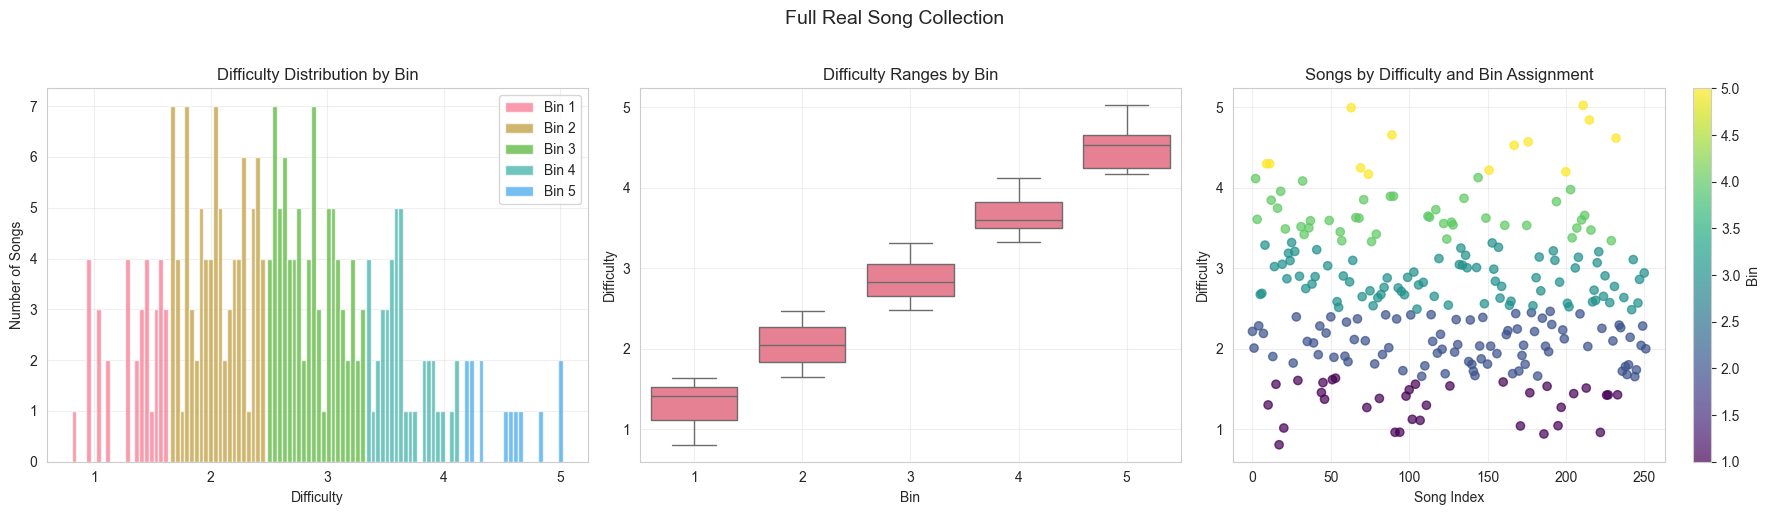


📊 Summary for Full Real Song Collection:
   Total songs: 252
   Songs with difficulty: 252
   Difficulty range: 0.81 - 5.03
   Bins used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

   Songs per bin:
     Bin 1: 34 songs (avg difficulty: 1.33)
     Bin 2: 84 songs (avg difficulty: 2.06)
     Bin 3: 80 songs (avg difficulty: 2.86)
     Bin 4: 41 songs (avg difficulty: 3.64)
     Bin 5: 13 songs (avg difficulty: 4.51)


In [14]:
# Analyze the full collection
print("🔍 Analyzing current binning algorithm with all real songs")
print("=" * 70)

if len(songs_with_difficulty) > 0:
    full_collection_df = analyze_binning(songs_with_difficulty)
    visualize_binning(full_collection_df, "Full Real Song Collection")
else:
    print("⚠️ No songs with difficulty values found. Cannot perform analysis.")

## Interactive Analysis with Real Data Subsets

In [15]:
# Interactive widget to explore different subsets of real songs
def interactive_real_data_analysis(
    min_difficulty=1.0, max_difficulty=5.0, max_songs=50
):
    """Interactive analysis using real song data with filtering."""
    if len(songs_with_difficulty) == 0:
        print("⚠️ No songs with difficulty values available for analysis")
        return

    # Filter songs by difficulty range
    filtered_songs = []
    for song in songs_with_difficulty:
        try:
            diff = float(song.properties.get("difficulty", 0))
            if min_difficulty <= diff <= max_difficulty:
                filtered_songs.append(song)
        except (ValueError, TypeError):
            continue

    # Limit number of songs if requested
    if max_songs and len(filtered_songs) > max_songs:
        # Sort by difficulty for consistent selection
        filtered_songs = sorted(
            filtered_songs, key=lambda s: float(s.properties.get("difficulty", 0))
        )
        filtered_songs = filtered_songs[:max_songs]

    print(
        f"📊 Analyzing {len(filtered_songs)} songs with difficulty {min_difficulty}-{max_difficulty}"
    )

    if len(filtered_songs) > 0:
        subset_df = analyze_binning(filtered_songs)
        title = f"Real Songs: Difficulty {min_difficulty}-{max_difficulty} (n={len(filtered_songs)})"
        visualize_binning(subset_df, title)
    else:
        print("⚠️ No songs found in the specified difficulty range")


# Create interactive widget
if len(songs_with_difficulty) > 0:
    # Get actual difficulty range from the data
    all_difficulties = []
    for song in songs_with_difficulty:
        try:
            diff = float(song.properties.get("difficulty", 0))
            all_difficulties.append(diff)
        except (ValueError, TypeError):
            continue

    if all_difficulties:
        min_real_diff = min(all_difficulties)
        max_real_diff = max(all_difficulties)
        print(
            f"📈 Real difficulty range in data: {min_real_diff:.2f} - {max_real_diff:.2f}"
        )

        interactive_plot = interactive(
            interactive_real_data_analysis,
            min_difficulty=widgets.FloatSlider(
                value=min_real_diff,
                min=min_real_diff,
                max=max_real_diff,
                step=0.1,
                description="Min Difficulty:",
            ),
            max_difficulty=widgets.FloatSlider(
                value=max_real_diff,
                min=min_real_diff,
                max=max_real_diff,
                step=0.1,
                description="Max Difficulty:",
            ),
            max_songs=widgets.IntSlider(
                value=50,
                min=10,
                max=len(songs_with_difficulty),
                step=10,
                description="Max Songs:",
            ),
        )
        display(interactive_plot)
    else:
        print("⚠️ No valid difficulty values found in real data")
else:
    print("⚠️ No songs with difficulty values available for interactive analysis")

📈 Real difficulty range in data: 0.81 - 5.03


interactive(children=(FloatSlider(value=0.806, description='Min Difficulty:', max=5.025, min=0.806), FloatSlid…

## Demonstrate Inconsistency with Real Data Editions

🎯 Demonstration: Binning Inconsistency Across Editions

📖 Analyzing Edition: 'complete' (Ukulele Tuesday - Complete Songbook)


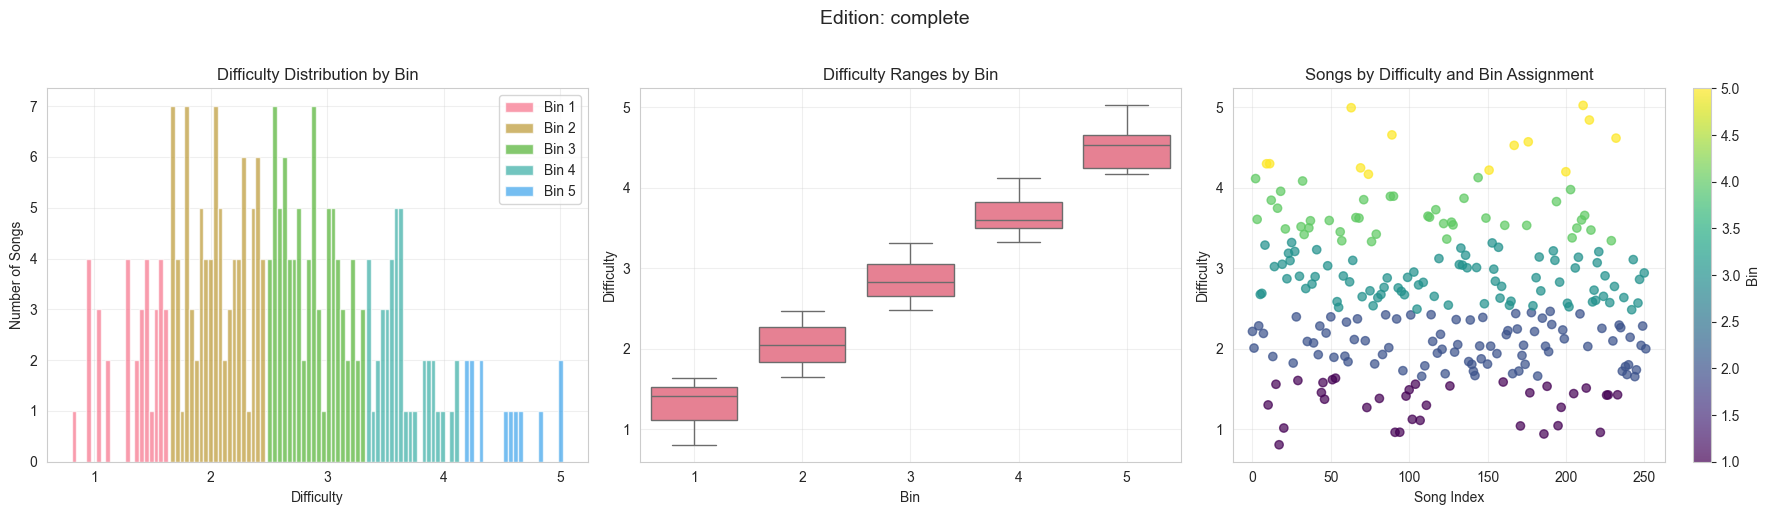


📊 Summary for Edition: complete:
   Total songs: 252
   Songs with difficulty: 252
   Difficulty range: 0.81 - 5.03
   Bins used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

   Songs per bin:
     Bin 1: 34 songs (avg difficulty: 1.33)
     Bin 2: 84 songs (avg difficulty: 2.06)
     Bin 3: 80 songs (avg difficulty: 2.86)
     Bin 4: 41 songs (avg difficulty: 3.64)
     Bin 5: 13 songs (avg difficulty: 4.51)

📖 Analyzing Edition: 'current' (Ukulele Tuesday - Current Songbook)


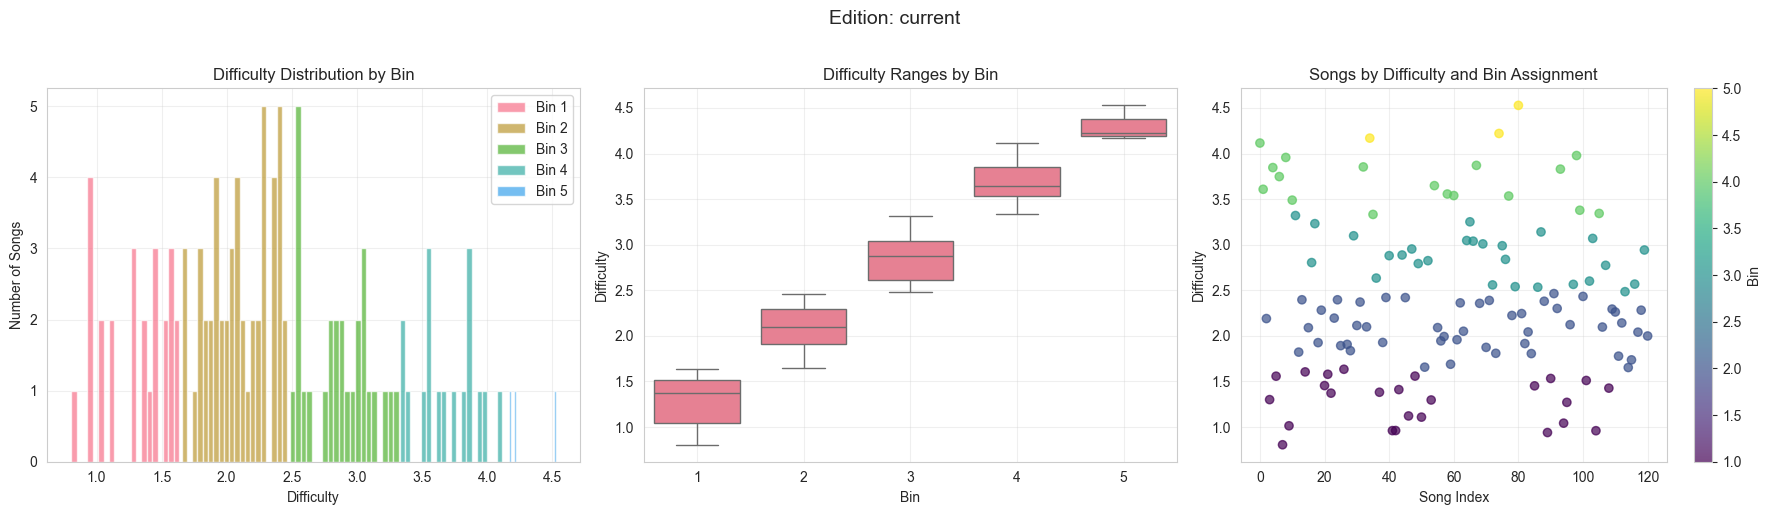


📊 Summary for Edition: current:
   Total songs: 121
   Songs with difficulty: 121
   Difficulty range: 0.81 - 4.53
   Bins used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

   Songs per bin:
     Bin 1: 25 songs (avg difficulty: 1.29)
     Bin 2: 49 songs (avg difficulty: 2.10)
     Bin 3: 27 songs (avg difficulty: 2.87)
     Bin 4: 17 songs (avg difficulty: 3.68)
     Bin 5:  3 songs (avg difficulty: 4.31)

📖 Analyzing Edition: 'ukulele-hooley-2025' (Ukulele Hooley 2025)


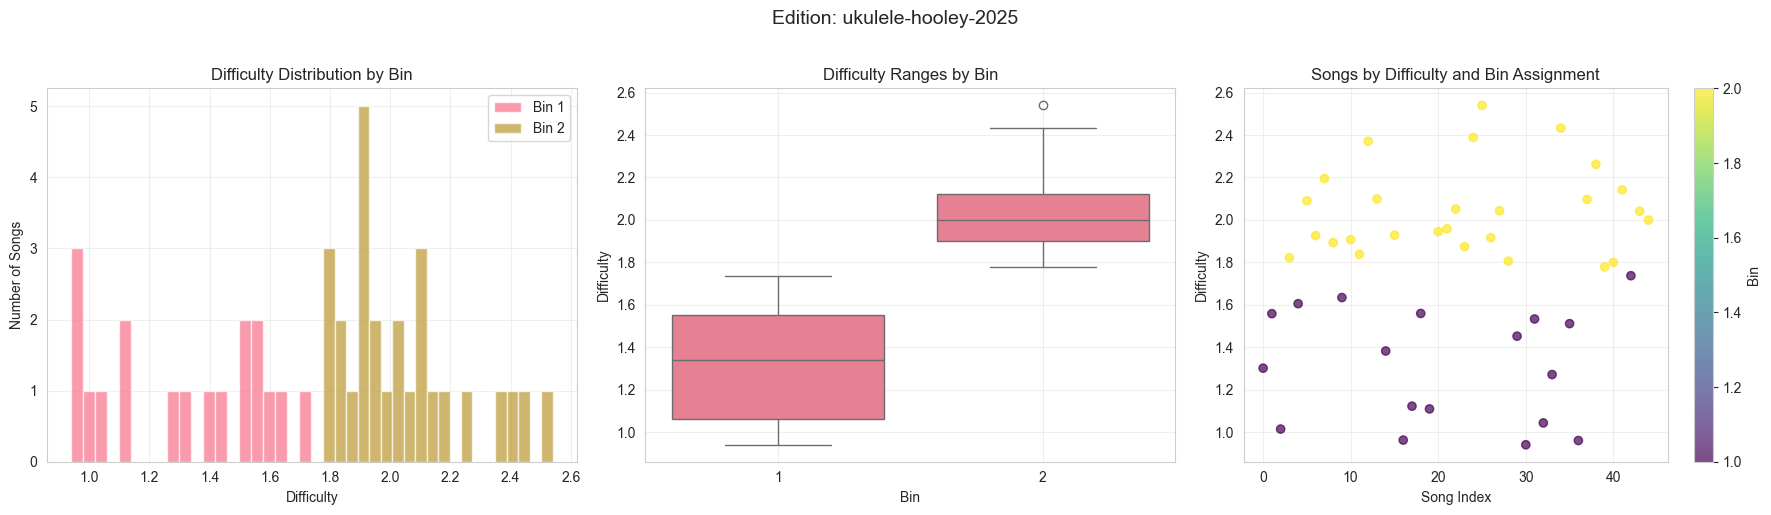


📊 Summary for Edition: ukulele-hooley-2025:
   Total songs: 45
   Songs with difficulty: 45
   Difficulty range: 0.94 - 2.54
   Bins used: [np.int64(1), np.int64(2)]

   Songs per bin:
     Bin 1: 18 songs (avg difficulty: 1.32)
     Bin 2: 27 songs (avg difficulty: 2.04)


🔄 Comparing Bin Assignments for Overlapping Songs
Found 122 songs in multiple editions.
Found 2 songs with inconsistent bin assignments.

Examples of inconsistent bin assignments:
                             Song Name  Difficulty complete current ukulele-hooley-2025
Nothing Compares 2 U - Sinéad O'Connor       2.540    Bin 3   Bin 3               Bin 2
              With Or Without You - U2       1.737    Bin 2   Bin 2               Bin 1


In [16]:
# Demonstrate how the same songs get different bins in different editions
print("🎯 Demonstration: Binning Inconsistency Across Editions")
print("=" * 60)

# Define editions to compare
editions_to_compare = ["complete", "current", "ukulele-hooley-2025"]
edition_data = {}

for edition_id in editions_to_compare:
    # Find the edition configuration
    edition_config = next((e for e in settings.editions if e.id == edition_id), None)
    if not edition_config:
        print(f"⚠️ Edition '{edition_id}' not found in settings.")
        continue
    
    print(f"\n📖 Analyzing Edition: '{edition_id}' ({edition_config.title})")

    # Use the filter from the edition config
    edition_filter = FilterGroup(operator="AND", filters=edition_config.filters)
    
    # Filter the full song list based on the edition's criteria
    edition_songs = [s for s in all_songs if edition_filter.matches(s.properties)]
    
    # Analyze binning for this edition's songs
    edition_songs_with_difficulty = get_songs_with_difficulty(edition_songs)
    if len(edition_songs_with_difficulty) > 0:
        edition_df = analyze_binning(edition_songs_with_difficulty)
        visualize_binning(edition_df, f"Edition: {edition_id}")
        edition_data[edition_id] = edition_df
    else:
        print(f"   No songs with difficulty found for edition '{edition_id}'.")

# --- Compare Bins Across Editions ---
print("\n\n🔄 Comparing Bin Assignments for Overlapping Songs")
print("=" * 60)

# Combine all edition data into one DataFrame
all_editions_df = pd.concat(
    [df.assign(edition=edition_id) for edition_id, df in edition_data.items()], 
    ignore_index=True
)

# Find songs that appear in more than one edition
song_counts = all_editions_df.groupby("name")["edition"].nunique()
overlapping_songs = song_counts[song_counts > 1].index

if not overlapping_songs.empty:
    # Filter to only overlapping songs
    comparison_df = all_editions_df[all_editions_df["name"].isin(overlapping_songs)]
    
    # Pivot to show bins for each edition side-by-side
    pivot_df = comparison_df.pivot_table(
        index=["name", "difficulty"], columns="edition", values="bin"
    ).reset_index()
    
    # Find songs where the bin assignment is inconsistent
    bin_columns = [col for col in pivot_df.columns if col not in ["name", "difficulty"]]
    inconsistent_df = pivot_df[pivot_df[bin_columns].nunique(axis=1, dropna=True) > 1]
    
    print(f"Found {len(overlapping_songs)} songs in multiple editions.")
    print(f"Found {len(inconsistent_df)} songs with inconsistent bin assignments.")
    
    if not inconsistent_df.empty:
        print("\nExamples of inconsistent bin assignments:")
        # Clean up for display
        display_df = inconsistent_df.rename(columns={"name": "Song Name", "difficulty": "Difficulty"})
        for col in bin_columns:
            display_df[col] = display_df[col].apply(lambda x: f"Bin {int(x)}" if pd.notna(x) else "N/A")
        
        # Display the table
        print(display_df.to_string(index=False))
    else:
        print("\n✅ All overlapping songs have consistent bin assignments.")
else:
    print("\n⚠️ No songs found in more than one edition to compare.")

## Compare Relative vs Absolute Binning

⚖️ Comparison: Relative vs Absolute Binning


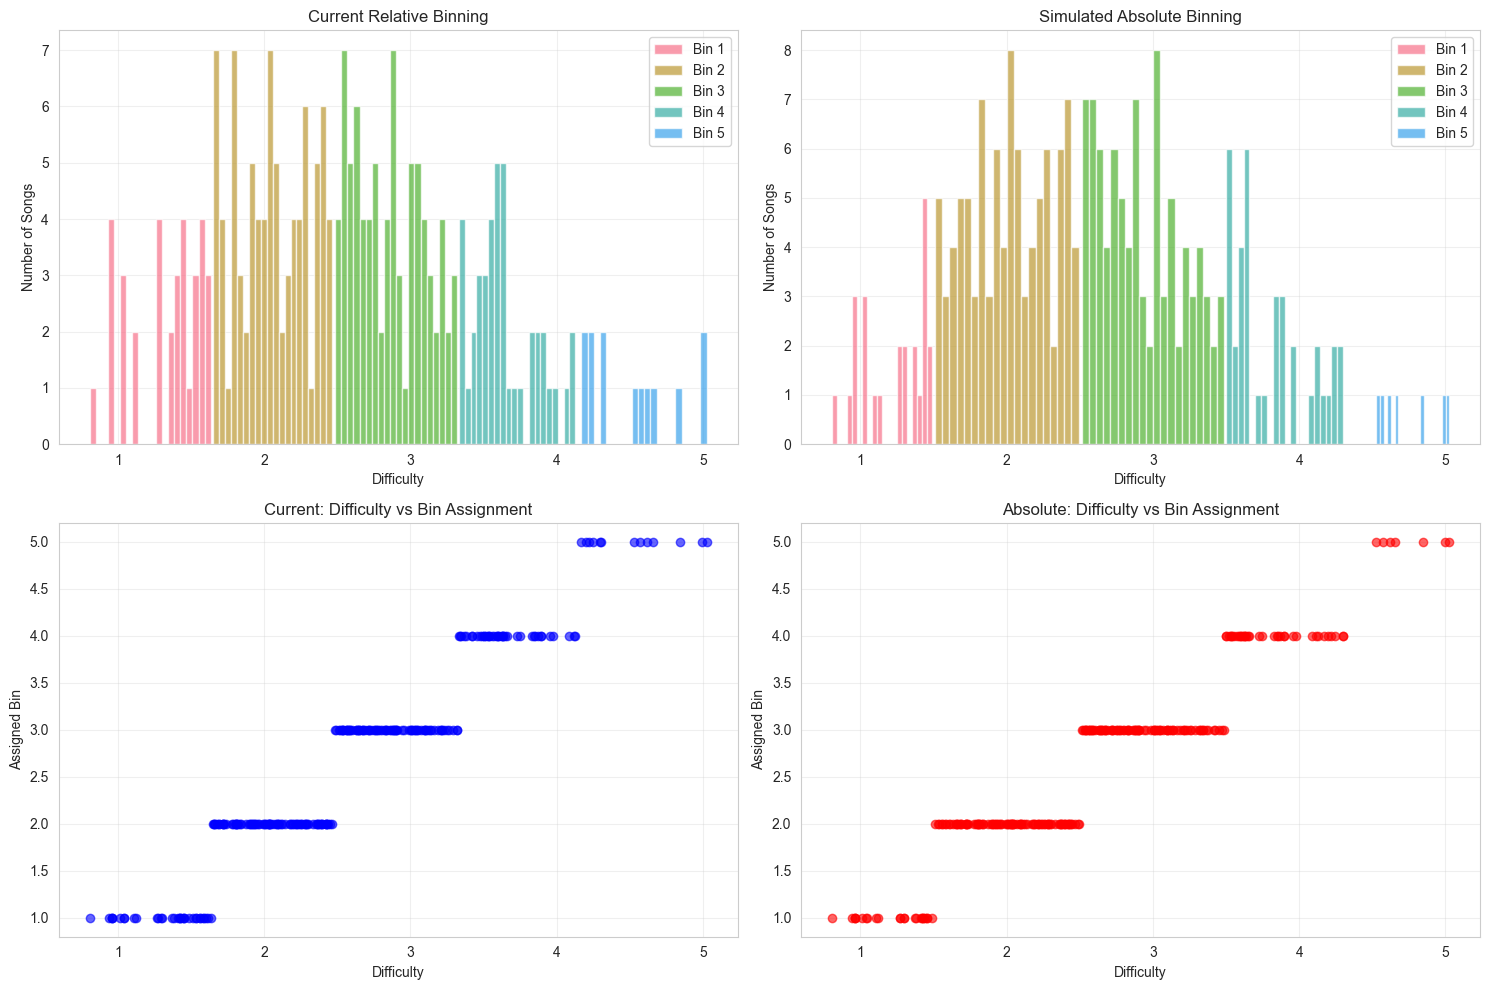


🔄 Songs that would change bins: 28/252 (11.1%)

Examples of songs that would change bins:
                                           Song Name  Difficulty  Current Bin  Absolute Bin
                              All Star - Smash Mouth       4.299            5             4
                  All The Things She Said - t.A.T.u.       4.300            5             4
An Poc Ar Buile (The Mad Puck Goat) - The Chieftains       1.558            1             2
                             Basket Case - Green Day       3.489            4             3
                    Blue Suede Shoes - Elvis Presley       1.605            1             2
              Born in the U.S.A. - Bruce Springsteen       3.420            4             3
                             Chaise Longue - Wet Leg       1.579            1             2
Comptine d'un autre été, l'après-midi - Yann Tiersen       1.615            1             2
                                   Creep - Radiohead       1.634            1    

In [17]:
# Compare current relative binning with absolute binning using real data
print("⚖️ Comparison: Relative vs Absolute Binning")
print("=" * 50)

if len(songs_with_difficulty) > 0:
    compare_binning_approaches(songs_with_difficulty)
else:
    print("⚠️ No songs with difficulty values available for comparison")

## Edge Cases and Real Data Insights

In [ ]:
# Analyze edge cases in the real data
print("⚠️ Edge Cases and Insights from Real Data")
print("=" * 50)

if len(songs_with_difficulty) > 0:
    # Get all difficulties
    real_difficulties = []
    for song in songs_with_difficulty:
        try:
            diff = float(song.properties.get("difficulty", 0))
            real_difficulties.append(diff)
        except (ValueError, TypeError):
            continue

    print("📊 Real data statistics:")
    print(f"   Number of songs: {len(real_difficulties)}")
    print(
        f"   Difficulty range: {min(real_difficulties):.2f} - {max(real_difficulties):.2f}"
    )
    print(f"   Mean difficulty: {np.mean(real_difficulties):.2f}")
    print(f"   Standard deviation: {np.std(real_difficulties):.2f}")

    # Test edge case: What if we only had very easy songs?
    very_easy_songs = [
        s
        for s in songs_with_difficulty
        if float(s.properties.get("difficulty", 0)) <= 2.0
    ]

    if len(very_easy_songs) >= 5:
        print("\n🔸 Edge Case: Only Very Easy Songs (≤2.0 difficulty)")
        easy_df = analyze_binning(very_easy_songs)
        visualize_binning(easy_df, "Edge Case: Only Very Easy Songs")

    # Test edge case: What if we only had very hard songs?
    very_hard_songs = [
        s
        for s in songs_with_difficulty
        if float(s.properties.get("difficulty", 0)) >= 4.0
    ]

    if len(very_hard_songs) >= 5:
        print("\n🔸 Edge Case: Only Very Hard Songs (≥4.0 difficulty)")
        hard_df = analyze_binning(very_hard_songs)
        visualize_binning(hard_df, "Edge Case: Only Very Hard Songs")

    # Test what happens with outliers
    outlier_threshold = np.mean(real_difficulties) + 2 * np.std(real_difficulties)
    outlier_songs = [
        s
        for s in songs_with_difficulty
        if float(s.properties.get("difficulty", 0)) >= outlier_threshold
    ]

    if len(outlier_songs) > 0:
        print(
            f"\n🔸 Outlier Analysis: {len(outlier_songs)} songs with difficulty ≥{outlier_threshold:.2f}"
        )
        print("   These outlier songs can skew the entire binning distribution")

        # Compare with and without outliers
        songs_without_outliers = [
            s
            for s in songs_with_difficulty
            if float(s.properties.get("difficulty", 0)) < outlier_threshold
        ]

        if len(songs_without_outliers) >= 10:
            print("\n   Without outliers:")
            no_outlier_df = analyze_binning(songs_without_outliers)
            visualize_binning(no_outlier_df, "Real Data Without Outliers")

            print("\n   With outliers:")
            with_outlier_df = analyze_binning(songs_with_difficulty)
            visualize_binning(with_outlier_df, "Real Data With Outliers")

else:
    print("⚠️ No songs with difficulty values available for edge case analysis")

## Key Findings and Recommendations

Based on the analysis of real song data from Google Drive, this notebook demonstrates several critical issues with the current difficulty binning algorithm:

### 🚨 Key Issues Identified

1. **Inconsistent binning**: The same song gets different bin assignments depending on what other songs are in the collection
2. **Sensitivity to outliers**: Adding very hard songs shifts all existing song assignments
3. **Over-amplification**: Small difficulty ranges get exaggerated across the full bin spread
4. **Context dependency**: Bin assignments are not predictable or stable

### 📋 Recommendations

1. **Implement absolute binning** with fixed difficulty ranges (e.g., 1.0-1.5 = Bin 1, 1.5-2.5 = Bin 2, etc.)
2. **Consider percentile-based binning** using historical data to ensure consistent distribution
3. **Add configuration options** for binning method selection
4. **Expand test coverage** for the identified edge cases
5. **Monitor binning consistency** in production to detect when algorithms produce unexpected results

The analysis with real data provides concrete evidence that the current relative approach creates unpredictable user experiences and should be replaced with a more stable algorithm.
